In [1]:
import numpy as np
from scripts.helpers import load_csv_data

np.random.seed(1)

In [2]:
train_fname = "data/train.csv"
test_fname = "data/test.csv"

y_train, X_train, ids_train = load_csv_data(train_fname)
y_test, X_test, ids_test = load_csv_data(test_fname)

print(X_train.shape, y_train.shape, ids_train.shape)
print(X_test.shape, y_test.shape, ids_test.shape)

(250000, 30) (250000,) (250000,)
(568238, 30) (568238,) (568238,)


Number of train subsets: 8
Number of test subsets:  8

Train shape:  (73790, 18)   Test shape: (168195, 18)
Train shape:  (26123, 17)   Test shape:  (59263, 17)
Train shape:  (69982, 22)   Test shape: (158095, 22)
Train shape:   (7562, 21)   Test shape:  (17243, 21)
Train shape:  (47427, 29)   Test shape: (107905, 29)
Train shape:   (2952, 28)   Test shape:   (6743, 28)
Train shape:  (20687, 29)   Test shape:  (47555, 29)
Train shape:   (1477, 28)   Test shape:   (3239, 28)

[ 0.47734343 -0.13022143  1.04760896 -1.66549015  0.1493726  -1.500117
 -0.04790099 -0.35834149  0.03095506 -0.26197338  0.44304876 -2.1193711
 -0.9650885  -0.03260867  0.58906858  0.58374653  0.20106434  1.65683906
 -0.64476133  0.19843401  0.4392428  -0.16347295 -0.35713617  1.69934306
  0.9625348   1.05112956  0.16672789 -1.8621725 ]


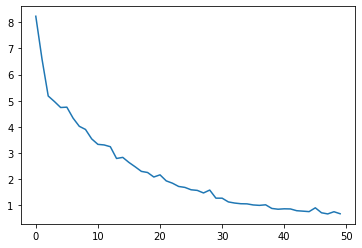

In [9]:
from preprocessing import PRI_jet_num_split, standardize
from models import least_squares_SGD

combine_vals = False

train_subsets = PRI_jet_num_split(y_train, X_train, ids_train, combine_vals)
test_subsets = PRI_jet_num_split(y_test, X_test, ids_test, combine_vals)

print(f"Number of train subsets: { len(train_subsets) }")
print(f"Number of test subsets:  { len(test_subsets) }")
print()

assert len(train_subsets) == len(test_subsets)

num_subsets = len(train_subsets)

for i in range(num_subsets):
    y_train_subset, X_train_subset, ids_train_subset = train_subsets[i]
    y_test_subset, X_test_subset, ids_test_subset = test_subsets[i]
    
    X_train_subset, X_test_subset = standardize(X_train_subset, X_test_subset)

    N, D = X_train_subset.shape

    initial_w = np.random.randn(D)
    gamma = 0.03
    
    print(f"Train shape: {str(X_train_subset.shape):>12}   Test shape: {str(X_test_subset.shape):>12}")
    
print()
    
losses, ws = least_squares_SGD(y_train_subset, X_train_subset, initial_w, 20, 50, gamma)

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(losses)
print(ws[-1])